# Align wq rigidly

Rigidly align ωq data along the energy axis <br />
TODO: incorporate functions into tools

# Load functions and modules

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

import hyperspy.api as hs

from scipy.signal import correlate, correlation_lags
from tqdm import tqdm

from hoglundTools._hyperspy import get_wq_rigid_shifts, shift_Signal2D_along_axis

# Create the data

Shifts (units)
[[   0.  100.  400.  900. 1600.]
 [2500. 3600. 4900. 6400. 8100.]]
Shifts  (px)
[[  0.  10.  40.  90. 160.]
 [250. 360. 490. 640. 810.]]


  0%|          | 0/10 [00:00<?, ?it/s]

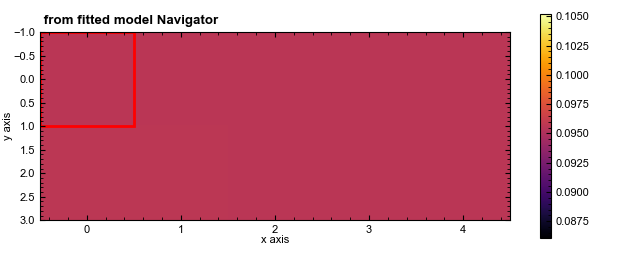

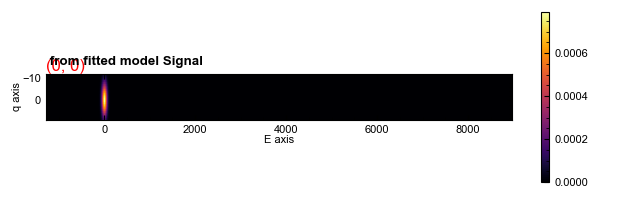

In [2]:
axes = [dict(name='y', navigate=True,  scale=2, offset=0, size=2),
        dict(name='x', navigate=True,  scale=1, offset=0, size=5),
        dict(name='q', navigate=False, scale=1, offset=-11.5, size=21),
        dict(name='E', navigate=False, scale=10., offset=-1280., size=1024)
       ]
si = hs.signals.Signal2D(np.zeros((2,5,21,1024)), axes=axes)
#si.plot()
si = si.create_model()
g = hs.model.components2D.Gaussian2D(A=1.0, sigma_x=40., sigma_y=5., centre_x=0.0, centre_y=0)
si.append(g)
shift = 10.
shifts_in = ((np.arange(0,si.axes_manager.navigation_size)*shift)**2).reshape(g.centre_x.map['values'].shape)
shifts_in_px = shifts_in/si.axes_manager['E'].scale

print(f'Shifts (units)\n{shifts_in}')
print(f'Shifts  (px)\n{shifts_in_px}')
g.centre_x.map['values'] = shifts_in
g.centre_x.map['is_set'] = True
si = si.as_signal()
si.plot()

# Rigid alignment

Measure the shifts

In [3]:
shits_measured = get_wq_rigid_shifts(si, kwargs_correlate=dict(normalize=True))[...,0]
print('Measured shifts (units):\n',shits_measured)
print('Same as input:', np.all(shits_measured==shifts_in))

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 60.60it/s]

Measured shifts (units):
 [[   0.  100.  400.  900. 1600.]
 [2500. 3600. 4900. 6400. 8100.]]
Same as input: True


Correct the shifts

Shift shape:       (2, 5)
Signal data shape: (2, 5, 21, 1024)
[########################################] | 100% Completed | 107.71 ms


C:\Users\e81\Documents\GitHub\hyperspy\hyperspy\signal.py:3810: RuntimeWarning: Mean of empty slice
  function(self.data, axis=ar_axes,))


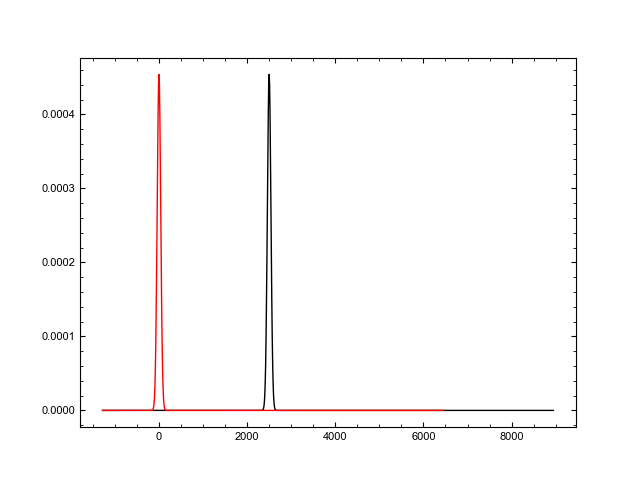

In [4]:
print('Shift shape:      ',shits_measured.shape)
print('Signal data shape:',si.data.shape)
si_fixed = si.deepcopy()
shift_Signal2D_along_axis(si_fixed, shits_measured, axis='E')
fig, ax = plt.subplots()
ax.plot(si.axes_manager['E'].axis, si.inav[0,1].nanmean('q'), '-', label='raw (0,1)')
ax.plot(si_fixed.axes_manager['E'].axis, si_fixed.inav[0,1].nanmean('q'), '-', label='fixed (0,1)')

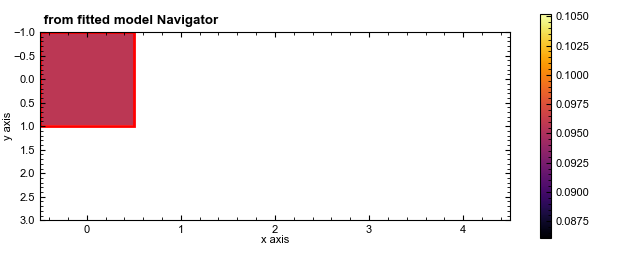

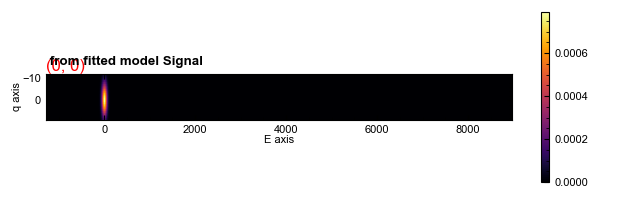

In [5]:
si_fixed.plot()